# compute a rotary spectrum of surface currents and zonally averages it

Steps taken are:

- data rewriting with more appropriate chunks

- computation of spectra

- zonally averages it

See also [ryan's notebook](https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648) on pangeo.pydata.org


In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
%matplotlib inline

root_data_dir = '/work/ALT/swot/swotpub/LLC4320/'
work_data_dir = '/work/ALT/swot/aval/syn/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#print(cluster.job_script())
w = cluster.scale(30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.135.39.89:35276 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 19 Cores: 19 Memory: 760.00 GB


---
## Load and rechunk original data

In [5]:
# variables and faces to consider
V = ['SSU', 'SSV']

# the following two parameters allow a reduction of the computational load
# faces considered
F = range(2)  # full domain = range(13)
# number of time steps to consider, 0 for full time series
NT = 24*20*4

# parameters for rechunking: time and space
Nt, Ni, Nj = 24*20, 188, 96

### rechunk one face at a time

Q: Are the chunks passed to open_mfdataset appropriate?

Q: `engine=h5netcdf` is not functional, unknown reason.

Ideally we would like not to loop around faces and let dask take care of this, this seems not to be doable here however.

**netcdf**: report on behavior with full dataset

**zarr**: should work great

In [7]:
# utility function
def load_data_nc(v, suff='_t*', files=None, **kwargs):
    default_kwargs = {'concat_dim': 'time',
                      'chunks': {'face':1},
                      'parallel': True}
    #                  'engine': 'h5netcdf',
    #
    #chunks': {'face':1, 'i': 480, 'j':480},
    #if v is 'SSU':
    #    default_kwargs['chunks'] = {'face':1, 'i_g': 480, 'j':480}
    #elif v is 'SSV':
    #    default_kwargs['chunks'] = {'face':1, 'i': 480, 'j_g':480}
    #
    default_kwargs.update(kwargs)
    #
    files_in = root_data_dir+v+'/'+v+suff
    if files is not None:
        files_in = files
    ds = xr.open_mfdataset(files_in, 
                           **default_kwargs)     
    return ds

In [8]:
def load_data_zarr(v, suffix='_std'):
    return xr.open_zarr(work_data_dir+'rechunked/'+v+suffix+'.zarr')

In [9]:
zarr=True
overwrite=False

for v in V:

    print('--- Start '+v)

    if zarr:
        %time ds0 = load_data_zarr(v)
        # 1s
    else:
        %time ds0 = load_data_nc(v)
        #if v is 'SSU':
        #    dvars = ['face','i_g','j']
        #elif v is 'SSV':
        #    dvars = ['face','i','j_g']
        #%time ds0 = load_data_nc(v, drop_variables=dvars)
        # 9min37 with netcdf4
        # may want to try with coords and drop_variables options:
        # coords='all'
        # drop_variables=['face','i_g','j'] or ['face','i','j_g']
        # https://github.com/pydata/xarray/issues/2039
        
    for face in F:
        
        ds = ds0.isel(face=face)
        #
        if NT>0:
            it = slice(NT//Nt *Nt)
        else:
            it = slice(len(ds.time)//Nt *Nt)
        
        ds = ds.isel(time=it)
        #
        chunks = {'time': Nt, 'i': Ni, 'j': Nj}
        if v is 'SSU':
            chunks = {'time': Nt, 'i_g': Ni, 'j': Nj}
        elif v is 'SSV':
            chunks = {'time': Nt, 'i': Ni, 'j_g': Nj}
        ds = ds.chunk(chunks)
        
        # tmp, xarray zarr backend bug: 
        # https://github.com/pydata/xarray/issues/2278
        if zarr:
            del ds['iters'].encoding['chunks']
            del ds[v].encoding['chunks']
        
        file_out = work_data_dir+'tmp/%s_f%02d.zarr'%(v,face)
        #print(ds)
        if not os.path.isdir(file_out) or overwrite:
            %time ds.to_zarr(file_out, mode='w')
            # about 2min for NT = 24*20*4
            
        print(' %s face=%d  done ' %(v, face))


--- Start SSU
CPU times: user 1 s, sys: 127 ms, total: 1.13 s
Wall time: 1.18 s
CPU times: user 1min 12s, sys: 4.3 s, total: 1min 16s
Wall time: 1min 29s
 SSU face=0  done 
CPU times: user 1min 22s, sys: 4.02 s, total: 1min 26s
Wall time: 1min 43s
 SSU face=1  done 
--- Start SSV
CPU times: user 3.05 s, sys: 74.4 ms, total: 3.13 s
Wall time: 3.1 s
CPU times: user 1min 10s, sys: 3.09 s, total: 1min 13s
Wall time: 1min 25s
 SSV face=0  done 
CPU times: user 1min 14s, sys: 3.24 s, total: 1min 17s
Wall time: 1min 28s
 SSV face=1  done 


In [15]:
cluster.close()

---

## rotary spectra

In [10]:
# load grid data
grid_dir_nc = root_data_dir+'grid_nc/'

_hasface = ['CS', 'SN', 'Depth', 
            'dxC', 'dxG', 'dyC', 'dyG', 
            'hFacC', 'hFacS', 'hFacW', 
            'rA', 'rAs', 'rAw', 
            'XC', 'YC', 'XG', 'YG']
gfiles = glob(grid_dir_nc+'*.nc')
gv = [f.split('/')[-1].split('.')[0] for f in gfiles]
objs = []
for f, v in zip(gfiles, gv):
    if v in _hasface:
        objs.append(xr.open_dataset(f, chunks={'face':1}))
    else:
        objs.append(xr.open_dataset(f))
grd = xr.merge(objs)
grd_rspec = xr.merge([grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>


In [11]:
# utility functions in order to compute frequency spectra

def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 80*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [12]:
# spatial strides for decimation
dij=4
overwrite=False

for face in F:
    
    Efile = work_data_dir+'tmp/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile) or overwrite:
    
        # load data
        dsu = xr.open_zarr(work_data_dir+'tmp/%s_f%02d.zarr'%('SSU',face))
        dsv = xr.open_zarr(work_data_dir+'tmp/%s_f%02d.zarr'%('SSV',face))
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        
        # generate a complex vector variable
        ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

        # spatial subsetting
        ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))

        # should show the size of the dataset to know if we can load it in memory
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E(ds['SSUV'].isel(i=2,j=2))
        #
        E = get_E(ds['SSUV'], f=f)

        # store
        E = E.to_dataset()
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)
                

dataset size: 35.8 GB
CPU times: user 43.2 s, sys: 2.66 s, total: 45.8 s
Wall time: 1min 5s
--- face 0 done
dataset size: 35.8 GB
CPU times: user 46.6 s, sys: 2.73 s, total: 49.4 s
Wall time: 1min 11s
--- face 1 done


### inspect result

In [13]:
face=1
v = 'SSUV'
E = xr.open_zarr(work_data_dir+'tmp/%s_f%02d.zarr'%(v,face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (j: 1080, i: 1080, freq_time: 1920)>
dask.array<shape=(1080, 1080, 1920), dtype=float64, chunksize=(24, 47, 1920)>
Coordinates:
    Depth      (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    XC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    YC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316

 data size: 17.9 GB


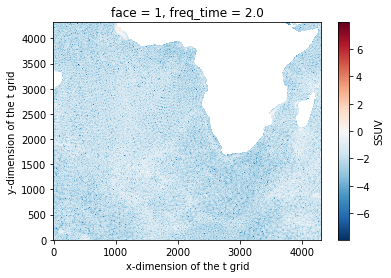

In [14]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

### concatenate all faces

In [15]:
v='SSUV'
E = xr.concat([xr.open_zarr(work_data_dir+'tmp/%s_f%02d.zarr'%(v,face)) 
               for face in F], dim='face', compat='identical')
#E = E.chunk({'i': 24, 'j':12})
print(E)
%time E.to_zarr(work_data_dir+'tmp/%s.zarr'%(v), mode='w')

<xarray.Dataset>
Dimensions:    (face: 2, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 0.0 0.0 0.0 0.0 ... 2531.0693 2131.7 2131.7
    XC         (face, j, i) float32 -114.93228 -114.93183 ... 51.84375 51.927082
    YC         (face, j, i) float32 -88.17715 -88.18883 ... 13.672233 13.672233
  * face       (face) int64 0 1
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(2, 1080, 1080, 1920), chunksize=(1, 24, 47, 1920)>
CPU times: user 13.1 s, sys: 837 ms, total: 14 s
Wall time: 23.5 s


---

## zonal averages

In [16]:
v='SSUV'
# concatenates faces
#ds = xr.concat([xr.open_zarr(work_data_dir+'spectra/%s_f%02d.zarr'%(v,face))
#               .chunk({'i': 24, 'j':12}) 
#               for face in range(13)], dim='face', compat='identical')
# or load concatenated spectra
ds = xr.open_zarr(work_data_dir+'tmp/%s.zarr'%(v)) #.isel(face=slice(0,2))
ds = ds.drop(['XC'])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:    (face: 2, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(2, 1080, 1080), chunksize=(1, 270, 540)>
    YC         (face, j, i) float32 dask.array<shape=(2, 1080, 1080), chunksize=(1, 270, 540)>
  * face       (face) int64 0 1
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(2, 1080, 1080, 1920), chunksize=(1, 24, 47, 1920)>

 data size: 35.9 GB


In [17]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [18]:
for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.SSUV.where(lds.Depth>200., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'tmp/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done


### Reload data, completes the zonal averaging and plot

In [19]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'tmp/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1920, latitude: 119)>
dask.array<shape=(1920, 119), dtype=float64, chunksize=(1920, 119)>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


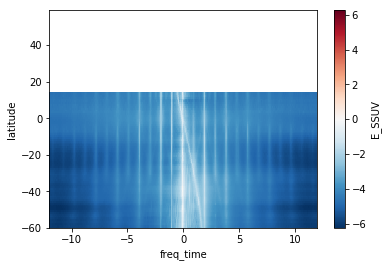

In [20]:
np.log10(E_zav).plot(x='freq_time', y='latitude')

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [21]:
cluster.close()